# Sentiment Analysis for Equity Portfolio Construction

1. Equity universe data collection
2. Data cleaning
3. News collection
4. Sentiment analysis
5. Statistics
6. Data visualization
7. Stock data collection
8. Performance
9. A very basic API

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

from datetime import datetime
import datetime as dt

import requests
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

import nltk #nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

<a id='1'></a>
## 1. Equity universe data collection

In [3]:
# Define url for websraping news
finwiz_url = 'https://finviz.com/quote.ashx?t='

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
page = requests.get(url)
soup = BeautifulSoup(page.text, 'lxml')

table = soup.find('table', {'class':'wikitable sortable'})
#table

rows = table.find_all('tr')

# Inspect the data 
#for row in rows:
#    print(row)

# Web-scrape Wikipedia
companies = []
tickers = []
sectors = []
added_dates = [] 

for row in rows[1:]:
    company = row.find_all('td')[1].text
    ticker = row.find_all('td')[0].text   
    sector = row.find_all('td')[3].text
    added_date = row.find_all('td')[6].text
    companies.append(company)
    tickers.append(ticker)
    sectors.append(sector)
    added_dates.append(added_date)

df = pd.DataFrame.from_dict({'Company'   : companies,
                             'Ticker' : tickers,
                             'Sector' : sectors,
                             'Date first added' : added_dates
                             })
for col in df.columns:
    df[col] = df[col].apply(lambda x : x.replace("\n", ""))
df

,Company,Ticker,Sector,Date first added
0,3M,MMM,Industrials,1976-08-09
1,A. O. Smith,AOS,Industrials,2017-07-26
2,Abbott,ABT,Health Care,1964-03-31
3,AbbVie,ABBV,Health Care,2012-12-31
4,Abiomed,ABMD,Health Care,2018-05-31
...,...,...,...,...
499,Yum! Brands,YUM,Consumer Discretionary,1997-10-06
500,Zebra,ZBRA,Information Technology,2019-12-23
501,Zimmer Biomet,ZBH,Health Care,2001-08-07
502,Zions Bancorp,ZION,Financials,2001-06-22


We obtained a dataframe that contains all S&P500 companies. 

<a id='2'></a>
## 2. Data cleaning

When merging data from different sources, a common issue is data discrepancy. We inspect the data we found on Wikipedia and we see that:
- there is a problem with "Ball Corporation" whose ticker was BALL on Wiki, but BLL on Finviz.
- companies with a point in their ticker (BRK.B and BF.B) are renamed as there are two class of equities on Finviz

With the following code we check the existance of Finviz pages for each ticker so that we can handle those errors.

In [4]:
error_list=[]
from urllib.error import HTTPError
for ticker in tqdm(df["Ticker"]):
    try:
        myurlopen = urlopen(Request(url=('https://finviz.com/quote.ashx?t='+str(ticker)),headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}))
    except HTTPError:
            print(f"Oops! {ticker} is not a valid ticker.")
            error_pos=df[df["Ticker"]==ticker].index
            error_list.append(error_pos)
error_list

 13%|██████████▍                                                                      | 65/504 [00:24<02:36,  2.80it/s]

Oops! BRK.B is not a valid ticker.


 16%|█████████████                                                                    | 81/504 [00:30<02:44,  2.57it/s]

Oops! BF.B is not a valid ticker.


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [03:05<00:00,  2.72it/s]


[Int64Index([64], dtype='int64'), Int64Index([80], dtype='int64')]

We research (manually) how should we fix this problem. We find that there are two classes of stocks, named -A and -B. We find that the most covered stock for BRK is BRK-A, while for BF is BF-B. So we apply those changes to our dataframe.

In [5]:
df[df["Ticker"].str.contains("\.")]

,Company,Ticker,Sector,Date first added
64,Berkshire Hathaway,BRK.B,Financials,2010-02-16
80,Brown–Forman,BF.B,Consumer Staples,1982-10-31


In [6]:
import warnings
warnings.filterwarnings("ignore")

df["Ticker"]=df["Ticker"].str.replace("BRK.B", "BRK-A")
df["Ticker"]=df["Ticker"].str.replace("BF.B", "BF-B")

In [7]:
len(df[df["Ticker"].str.contains("\.")])

0

We can now drop the BALL ticker or research (manually) for a solution. We see that there is an error in the ticker and the correct one is BLL. So we change the ticker, but this operation is not automatized.

In [7]:
df["Ticker"]=df["Ticker"].str.replace("BALL", "BLL")

Now, all tickers should be found on Finviz

<a id='3'></a>
## 3. News collection

We collect the news from the open source website Finviz. With this code, we collect ALL past news, and then we select a sub timeframe (yes, it can be optimized).

In [8]:
news_tables = {}
# take all the tickers, maybe of all stock indices, or do a try/if statement to 
# select only the news where we have data
#tickers = ['AMZN', 'TSLA', 'GOOG']
tickers=df.iloc[:,1]
for ticker in tqdm(tickers):
    #print(ticker)
    url2 = finwiz_url + ticker
    req = Request(url=url2,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response, features="lxml")
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table
    
    
# Read the past available news for all the companies
# you can also select one particular company, ie AMZN
for ticker in tickers:
    amzn=news_tables[ticker]
# Get all the table rows tagged in HTML with <tr> into the specific ticker
    amzn_tr = amzn.findAll('tr')
    for i, table_row in enumerate(amzn_tr):
        # Read the text of the element 'a' into 'link_text'
        a_text = table_row.a.text
        # Read the text of the element 'td' into 'data_text'
        td_text = table_row.td.text
     
parsed_news = []

# Iterate through the news
for file_name, news_table in tqdm(news_tables.items()):
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])  

100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [00:05<00:00, 99.84it/s]


We print some lines of the dictionary parsed_news:

In [19]:
for i in [0,100,1000,10000]:
    print(parsed_news[i])

['MMM', 'May-25-22', '11:15AM', "One million trees' worth of smog-fighting capacity has been installed on roofs using Malarkey Roofing Products shingles with 3M Smog-reducing Granules."]
['AOS', 'May-25-22', '11:52AM', 'These 2 Under-the-Radar Stocks Have Incredibly Bright Futures']
['AAP', 'May-25-22', '01:56PM', "TBJ Plus: Triangle's Fortune 500 standing; WRAL anchor says goodbye; Tom Cruise 'Top Gun' promo's NC link"]
['CF', 'Apr-27-22', '03:03PM', 'CF Industries (CF) Reports Next Week: Wall Street Expects Earnings Growth']


which has dimensions:

In [20]:
len(parsed_news)

50060

Note that the third column (time) stresses the fact that sentiment data are high-frequency data in the sense that they are unevenly spaced. As this is just an introductory work on the subject, I will compute moving average to smooth the data but a real trading strategy should consider more advanced econometric methods.

<a id='4'></a>
## 4. Sentiment analysis

In [130]:
# Set the sentiment intensity analyzer
start_date = '2022-01-01'
end_date = '2022-05-22'

vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

print('Computing polarity score...')
# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

#parsed_and_scored_news
#scores_df

print('Date filtering...')
# Date filtering
parsed_and_scored_news["date"]=parsed_and_scored_news["date"].astype('str') 
parsed_and_scored_news=parsed_and_scored_news.sort_values("date")
after_start_date = parsed_and_scored_news["date"] >= start_date
before_end_date = parsed_and_scored_news["date"] <= end_date
news_filtered = parsed_and_scored_news.loc[after_start_date].loc[before_end_date]

print('Writing a CSV file...')
# CSV writing
# useful to retrieve data for the next two sections
# files will be stored in the user directory
parsed_and_scored_news.to_csv('out.csv', index=False)
news_filtered.to_csv('news_filtered.csv', index=False)
df.to_csv('df.csv', index=False)
tickers.to_csv('tickers.csv', index=False)

news_filtered

Computing polarity score...
Date filtering...
Writing a CSV file...


,ticker,date,time,headline,neg,neu,pos,compound
5073,AIZ,2022-01-01,06:07AM,Can Mixed Financials Have A Negative Impact on...,0.222,0.778,0.000,-0.5719
4862,APTV,2022-01-01,06:26AM,Does This Valuation Of Aptiv PLC (NYSE:APTV) I...,0.000,1.000,0.000,0.0000
7840,BRO,2022-01-01,07:04AM,Brown & Brown's (NYSE:BRO) five-year earnings ...,0.000,0.809,0.191,0.3818
12538,ED,2022-01-01,08:07AM,A number of insiders bought Consolidated Ediso...,0.000,0.735,0.265,0.6597
13939,DRI,2022-01-01,08:02AM,Estimating The Fair Value Of Darden Restaurant...,0.000,0.598,0.402,0.5719
...,...,...,...,...,...,...,...,...
7615,AVGO,2022-05-22,11:40PM,Chipmaker Broadcom in talks to buy VMware for ...,0.000,1.000,0.000,0.0000
14669,DLR,2022-05-22,09:21AM,3 Really Good Reasons to Invest in Data Center...,0.000,0.715,0.285,0.4927
43635,TGT,2022-05-22,12:29PM,"Bear market, GDP, and Davos: What to watch thi...",0.000,1.000,0.000,0.0000
2479,GOOGL,2022-05-22,07:00AM,3 Stocks Down More Than 75% to Buy Right Now,0.000,1.000,0.000,0.0000


The sentiment analysis returns a dataframe that includes data from the precedent dictionary (scraped from Finviz) plus four scores: negative, neutral, positive, and a compound score. In our analysis, we will use the compound score. The lenght of the dataframe is of course smaller than the one of the previous dictionary as we filtered by date.

When setting a start and end date, mind that some past news are deleted from Finviz so there will be many missing data and the backtest will be unsuccessful.

Data visualization:

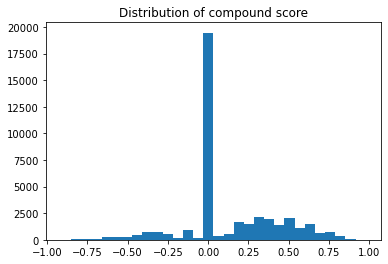

In [131]:
plt.hist(news_filtered.compound, bins=30)
plt.title('Distribution of compound score')
plt.show()

We find that the compound score (the one we will use) is not even fairly normal, and it has a pronounced peak at zero. This probably means that vader was unable to give a score to many news. This can be improved.

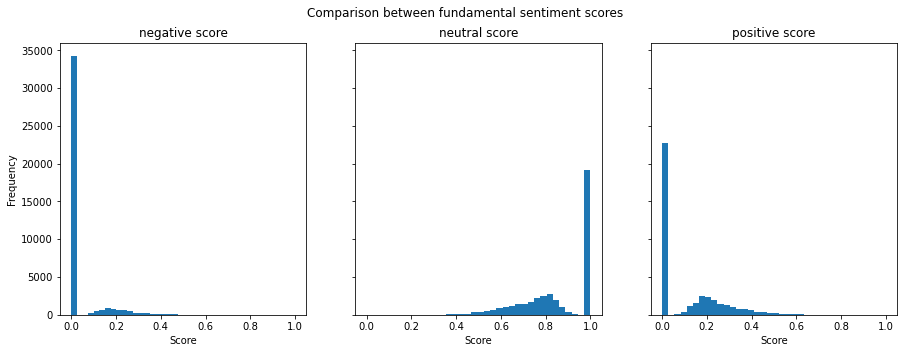

In [132]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15,5))

ax1.hist(news_filtered.neg, bins=30)
ax2.hist(news_filtered.neu, bins=30)
ax3.hist(news_filtered.pos, bins=30)

ax1.set_xlabel('Score')
ax2.set_xlabel('Score')
ax3.set_xlabel('Score')

ax1.set_ylabel('Frequency')

ax1.set_title('negative score')
ax2.set_title('neutral score')
ax3.set_title('positive score')

fig.suptitle('Comparison between fundamental sentiment scores')
plt.show()

We find that the high frequency of a compound scores equal to zero is caused by
- incabability of vader to detect negative news
- relatively high number of neutral news

whereas for positive news, the frequency of null score is lower than in the case of negative news. This is a major drawback of this work as we are very much interested in detecting negative news as those will cause a sell-off in a particular stock. Also, we know that humans react more negatively for negative news than they react positively for positive news (ie Kahneman-Tversky). So this is a MAJOR drawback.

<a id='5'></a>
## 5. Descriptive statistics

In [133]:
# Define some dataframes to store the top and bottom 5 companies, for each day
# IMPORTANT: weekends are included here as it is possible that journalists write a
# relevant article in those days. Though, those days will be excluded after because
# we would not be able to rebalance our portfolio in weekends as the stock market
# is closed

# Import files from the first part
d1 = pd.read_csv('out.csv')
news_filtered = pd.read_csv('news_filtered.csv')
df = pd.read_csv('df.csv')
tickers = pd.read_csv('tickers.csv')

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = news_filtered.groupby(['ticker','date']).mean()
plot_scores = mean_scores.groupby(['ticker']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()


print('Selecting best and worst sentiment companies...')
df_scores=pd.DataFrame(np.transpose(mean_scores))
df_scores=df_scores.loc[:,:'before_end_date'] # new line
df_top=pd.DataFrame(index=range(5))
df_bottom=pd.DataFrame(index=range(5))
top_tickers=[]
bottom_tickers=[]

for date in df_scores.columns:
    rank_temp=df_scores.loc[:,date]
    rank=rank_temp.reset_index(drop=True).dropna()
    
    top=rank.nlargest(5)
    bottom=rank.nsmallest(5)
    
    top_tickers.append(df_scores.index[top.index].to_list())
    bottom_tickers.append(df_scores.index[bottom.index].to_list())
    
    try:
        for i in range(5):
            df_top.loc[i,str(date)]=pd.DataFrame(top).iloc[i,0]
            df_bottom.loc[i,str(date)]=pd.DataFrame(bottom).iloc[i,0]
            
    except IndexError:
        for i in range(5):
            df_top.loc[i,str(date)]=''
            df_bottom.loc[i,str(date)]=''

# We can find the absolute and relative frequency of the tickers in the top/
# bottom dataframe, to understand to what extent the news are persistent 
# or not (temporary)
print('Computing basic statistics...')
count_top_tickers=pd.DataFrame(top_tickers)
cumsum_top_tickers=count_top_tickers.apply(pd.value_counts)
#relsum_top_tickers=cumsum_top_tickers/cumsum_top_tickers.apply(np.nansum)
#relsum_top_tickers.sort_values(by=relsum_top_tickers.columns)
ranked_top_tickers = cumsum_top_tickers.apply(lambda x: x.sort_values(ascending=False).values)
ranked_top_tickers['Sum_Top'] = ranked_top_tickers.sum(axis=1)
ranked_top_tickers = ranked_top_tickers.sort_values(by='Sum_Top', ascending=False)
#ranked_top_tickers

count_bottom_tickers=pd.DataFrame(bottom_tickers)
cumsum_bottom_tickers=count_bottom_tickers.apply(pd.value_counts)
#relsum_bottom_tickers=cumsum_bottom_tickers/cumsum_bottom_tickers.apply(np.nansum)
#relsum_bottom_tickers.sort_values(by=relsum_bottom_tickers.columns)
ranked_bottom_tickers = cumsum_bottom_tickers.apply(lambda x: x.sort_values(ascending=True).values)
ranked_bottom_tickers['Sum_Bottom'] = ranked_bottom_tickers.sum(axis=1)
ranked_bottom_tickers = ranked_bottom_tickers.sort_values(by='Sum_Bottom', ascending=False)
#ranked_bottom_tickers

# We now want to code a string that will return the top/bottom 3 tickers and 
# the relative company names
# this will be used in the API
top_company_index, top_company_name, top_company_names={},{},''
bottom_company_index, bottom_company_name, bottom_company_names={},{},''
punctuation=[', ',', and ','.']
for i in range(3):
    top_company_index[i]=df[df['Ticker']==str(ranked_top_tickers.index[i])].index.values
    top_company_name[i]=(df['Company'][top_company_index[i][0]])
    top_company_names += top_company_name[i]+punctuation[i]
for i in range(3):
    bottom_company_index[i]=df[df['Ticker']==str(ranked_bottom_tickers.index[i])].index.values
    bottom_company_name[i]=(df['Company'][bottom_company_index[i][0]])
    bottom_company_names += bottom_company_name[i]+punctuation[i]

# We store the results in four strings of text so that we can use them in the API

print('Writing txt files...')
f= open("text1.txt","w+")
text1=str(ranked_top_tickers.index[0]),' appeared ', str(int(ranked_top_tickers['Sum_Top'][0])),' times in the top 5 of the sentiment score year-to-date, followed by ',str(ranked_top_tickers.index[1]),' (',str(int(ranked_top_tickers['Sum_Top'][1])),' times), and ',str(ranked_top_tickers.index[2]),' (',str(int(ranked_top_tickers['Sum_Top'][2])),' times)'
for n in range(len(text1)):
    f.write(text1[n])
f.close()

f=open("text1.txt", "r")
if f.mode == 'r':
    print_text1 =f.read()
# 
f= open("text2.txt","w+")
text2=' In particular, the top 3 company names are ',top_company_names
for n in range(len(text2)):
    f.write(text2[n])
f.close()

f=open("text2.txt", "r")
if f.mode == 'r':
    print_text2 =f.read()
# 
f= open("text3.txt","w+")
text3=str(ranked_bottom_tickers.index[0]),' appeared ', str(int(ranked_bottom_tickers['Sum_Bottom'][0])),' times in the bottom 5 of the sentiment score year-to-date, followed by ',str(ranked_bottom_tickers.index[1]),' ('+str(int(ranked_bottom_tickers['Sum_Bottom'][1])),' times), and ',str(ranked_bottom_tickers.index[2]),' ('+str(int(ranked_bottom_tickers['Sum_Bottom'][2])),' times)'
for n in range(len(text3)):
    f.write(text3[n])
f.close()

f=open("text3.txt", "r")
if f.mode == 'r':
    print_text3 =f.read()
# 
f= open("text4.txt","w+")
text4=' In particular, the bottom 3 company names are ',bottom_company_names
for n in range(len(text4)):
    f.write(text4[n])
f.close()

f=open("text4.txt", "r")
if f.mode == 'r':
    print_text4 =f.read()
print('Done')

Selecting best and worst sentiment companies...
Computing basic statistics...
Writing txt files...
Done


In [134]:
if (top_tickers==bottom_tickers)==False:
    print('Top and bottom tickers successfully separed.')
else:
    print('Error in writing top and bottom tickers.')

Top and bottom tickers successfully separed.


We know what stock to buy:

In [135]:
count_top_tickers

,0,1,2,3,4
0,ED,DRI,BRO,APTV,EMN
1,IEX,ANSS,AJG,BSX,LNC
2,IFF,FDS,FBHS,CCI,KMX
3,ALLE,EIX,EPAM,XYL,PAYX
4,CTSH,BSX,PEG,FRT,SYF
...,...,...,...,...,...
137,CMS,DHI,TXT,WEC,KHC
138,HII,PAYC,ECL,QRVO,CTAS
139,PEG,BWA,WBA,ARE,CCI
140,MSFT,MS,COST,ALLE,LOW


and to sell, for each date:

In [137]:
count_bottom_tickers

,0,1,2,3,4
0,AIZ,APTV,EMN,BRO,DRI
1,CTVA,CPB,XEL,CNP,LNC
2,WTW,PPL,ADP,AEP,APTV
3,AEP,AJG,ABMD,ALGN,AMP
4,CAG,WM,DXC,AEE,AOS
...,...,...,...,...,...
137,MKC,SYY,LH,SPGI,HAL
138,ANET,VMC,WM,MTCH,ALL
139,LH,CLX,BMY,C,SCHW
140,SJM,ABT,DLR,PEAK,TJX


Note that sometimes a ticker is included in both lists. This means that on that day, there was only one news on finviz among companies in the index. We want to see how big is the issue:

In [138]:
for i in range(0,5):
    print(i+1,'^ column')
    print(list(set(count_top_tickers.iloc[:,i]) & set(count_bottom_tickers.iloc[:,i])))
    print('number of common stocks in top and bottom lists:')
    print(len(list(set(count_top_tickers.iloc[:,i]) & set(count_bottom_tickers.iloc[:,i]))))
    print('')

1 ^ column
['PPL', 'ETSY', 'DTE', 'KEY', 'CCI', 'DGX', 'HIG', 'HII', 'ILMN', 'TDG', 'CZR', 'CSX', 'AFL', 'WYNN', 'BR', 'NLOK', 'NSC', 'WTW', 'APTV', 'TAP', 'APD', 'EMN', 'TXT', 'RJF', 'DRI', 'CL', 'DISH', 'ARE', 'AEP', 'ED', 'CNC', 'SEDG', 'ANET', 'RHI', 'HBAN', 'LKQ']
number of common stocks in top and bottom lists:
36

2 ^ column
['IR', 'HOLX', 'SLB', 'CCI', 'AEE', 'WRK', 'EBAY', 'MCO', 'HII', 'NLOK', 'WTW', 'APD', 'VMC', None, 'NDAQ', 'UNP', 'TXT', 'DRI', 'FDS', 'DXCM', 'TMUS', 'RF', 'BEN', 'AMT', 'CHD', 'CFG', 'DPZ', 'EIX']
number of common stocks in top and bottom lists:
28

3 ^ column
['HON', 'SHW', 'VRSK', 'ITW', 'AWK', 'BKNG', 'WST', 'CCI', 'ISRG', 'CPT', 'ALLE', 'DLR', 'BWA', 'HII', 'AFL', 'ES', 'SJM', 'CAT', 'NWS', None, 'KIM', 'TXT', 'AJG', 'ADBE', 'TMUS', 'DOV', 'ARE', 'ED', 'NCLH', 'URI', 'CB', 'CTXS', 'XEL', 'KMI']
number of common stocks in top and bottom lists:
34

4 ^ column
['PSX', 'ETSY', 'BIIB', 'CE', 'AEE', 'LIN', 'WEC', 'MRK', 'WAB', 'NWSA', 'CHRW', 'DG', 'DGX', '

... without considering the cross intersection. Since we will use a long only strategy in the end, this is not a big issue, but in the prospective of a REAL trading algo, this must be solved. Most probably, this will be naturally solved by adopting a more precise sentiment analyser and / or by adopting a more complete news provider (mind that finviz is probably the only one which is available open source).

<a id='6'></a>
## 6. Data visualization

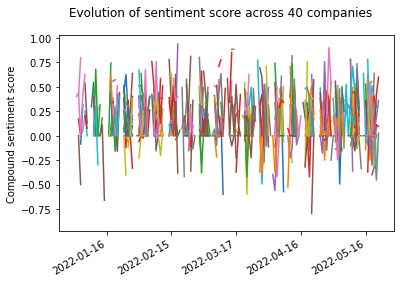

In [139]:
# set the interval of dates on x axis
my_interval=30

# set how many scores you want to visualize
my_comps=40

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

# set the number of days 
N = days_between(start_date, end_date)

#days = mdates.drange(datetime.strptime(start_date, "%Y-%m-%d"),
#                     datetime.strptime(end_date, "%Y-%m-%d")+dt.timedelta(days=1),
#                     dt.timedelta(days=1))

days = mdates.date2num(df_scores.columns)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=my_interval))
for i in range(my_comps):
    plt.plot(days, df_scores.iloc[i,:])
plt.gcf().autofmt_xdate()
plt.ylabel('Compound sentiment score')
plt.suptitle('Evolution of sentiment score across '+str(my_comps)+' companies')
plt.show()

As expected, there is a problem of missing data. In this case, the strategy cannot be run! We use moving averages to fill those vacuums but this is not doable in reality.

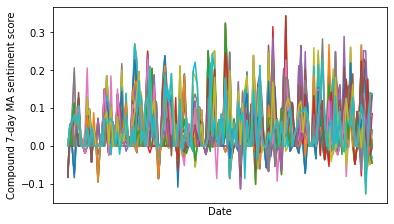

In [141]:
#data smoothing
moving_avg=7

df_scores_w=df_scores.fillna(0).rolling(moving_avg).mean()

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=my_interval))
for i in range(my_comps):
    plt.plot(df_scores_w.iloc[i,:])
plt.gcf().autofmt_xdate()
plt.xticks([])
plt.xlabel('Date')
plt.ylabel('Compound 7-day MA sentiment score')
fig.suptitle('Comparison between moving averages')
plt.show()

So the above graph is the moving average version of the graph before.

<a id='7'></a>
## 7. Stock data collection

In [142]:
# We use the YahooFinance API to download stock prices of the S&P500
import yfinance as yf

toptickers = ranked_top_tickers.index[0:3]
bottomtickers = ranked_bottom_tickers.index[0:3]

temp = pd.DataFrame
stockdata = []
print('Downloading preliminary stock data ...')
for i in range(len(toptickers)):
    temp = yf.download(toptickers[i],start_date,end_date, progress=False)
    stockdata.append(temp.iloc[:,4])

for i in range(len(bottomtickers)):
    temp = yf.download(bottomtickers[i],start_date,end_date, progress=False)
    stockdata.append(temp.iloc[:,4])

returndata=[]
for i in range(len(stockdata)):
    returndata.append(stockdata[i].pct_change())
    returndata[i]=returndata[i][1:]

returndata=pd.DataFrame(returndata).T
cum_return=(returndata.iloc[:,0:3].sum(axis=1)-returndata.iloc[:,3:6].sum(axis=1)+1).cumprod()

# compare with S&P500
spdata=[]
tickers.reset_index(drop=True,inplace=True)
sptemp = yf.download('^GSPC',start_date,end_date, progress=False)
spreturns=sptemp.iloc[:,4].pct_change() # the fifth column returns the adjusted close
spreturns=spreturns[1:]
cum_sp_returns=(spreturns+1).cumprod()
print('Preliminary stock data successfully downloaded')

# To avoid downloading two times the same data, we use a list where we delete 
# the double counted tickers
flat_top_list=[]
flat_top_list = [item for sublist in top_tickers for item in sublist]
flat_top_list=list(dict.fromkeys(flat_top_list))
df_toptickers=pd.DataFrame(top_tickers)

flat_bottom_list=[]
flat_bottom_list = [item for sublist in bottom_tickers for item in sublist]
flat_bottom_list=list(dict.fromkeys(flat_bottom_list))
df_bottomtickers=pd.DataFrame(bottom_tickers)


top_stockdata=[]
print('')
print('Running loop 1/2 ...')
for i in tqdm(range(len(flat_top_list))):
    temp = yf.download(flat_top_list[i],start_date,end_date, progress=False)
    top_stockdata.append(temp.iloc[:,4])
print('Loop 1/2 ended.')
print('')
print('Running loop 2/2 ...')
bottom_stockdata=[]
for i in tqdm(range(len(flat_bottom_list))):
    temp = yf.download(flat_bottom_list[i],start_date,end_date, progress=False)
    bottom_stockdata.append(temp.iloc[:,4])
print('Loop 2/2 ended.')

Preliminary stock data successfully downloaded

Running loop 1/2 ...


100%|████████████████████████████████████████████████████████████████████████████████| 331/331 [01:43<00:00,  3.20it/s]


Loop 1/2 ended.

Running loop 2/2 ...


100%|████████████████████████████████████████████████████████████████████████████████| 329/329 [07:14<00:00,  1.32s/it]

Loop 2/2 ended.


<a id='8'></a>
## 8. Performance

In [143]:
# download stock data for the stocks in top and bottom
top_returndata=[]
for i in range(len(top_stockdata)):
    top_returndata.append(top_stockdata[i].pct_change())
    top_returndata[i]=top_returndata[i][1:]
top_returndata=pd.DataFrame(top_returndata).T
top_returndata.columns=flat_top_list
top_returndata=top_returndata.fillna(0)

bottom_returndata=[]
for i in range(len(bottom_stockdata)):
    bottom_returndata.append(bottom_stockdata[i].pct_change())
    bottom_returndata[i]=bottom_returndata[i][1:]
bottom_returndata=pd.DataFrame(bottom_returndata).T
bottom_returndata.columns=flat_bottom_list
bottom_returndata=bottom_returndata.fillna(0)

# We now match the tickers in the top/bottom 5 with the returns
# and store the data in a new dataframe: top_dated_returndata
df_toptickers.index = df_scores_w.columns
df_toptickers.index = pd.to_datetime(df_toptickers.index)
top_dated_returndata=pd.DataFrame(index=top_returndata.index, columns=df_toptickers.columns)
returns_top=[]
for j in range(len(top_returndata.index)):
    for i in range(len(df_toptickers.columns)):
        #avoid weekends
        try:
            temp_ticker=df_toptickers.loc[top_returndata.index[j],:]
            temp_return=top_returndata.loc[top_returndata.index[j],temp_ticker[i]] 
            top_dated_returndata.iloc[j,i]=temp_return
        except KeyError:
            top_dated_returndata.iloc[j,i]=0

df_bottomtickers.index=df_scores_w.columns
df_bottomtickers.index = pd.to_datetime(df_bottomtickers.index)
bottom_dated_returndata=pd.DataFrame(index=bottom_returndata.index, columns=df_bottomtickers.columns)
returns_bottom=[]
for j in range(len(bottom_returndata.index)):
    for i in range(len(df_bottomtickers.columns)):
        #avoid weekends
        try:
            temp_ticker=df_bottomtickers.loc[bottom_returndata.index[j],:]
            temp_return=bottom_returndata.loc[bottom_returndata.index[j],temp_ticker[i]] 
            bottom_dated_returndata.iloc[j,i]=temp_return
        except KeyError:
            bottom_dated_returndata.iloc[j,i]=0

# We assign an equal weight of 0.2 to all assets in portfolio
# ie the objective is not to optimize the portfolio but to examine
# the naive return profile of a portfolio built upon a sentiment trading signal
w=1/len(top_dated_returndata.columns)
top_dated_returndata=w*top_dated_returndata
bottom_dated_returndata=w*bottom_dated_returndata

top_cum_return=(top_dated_returndata.sum(axis=1)+1).cumprod()
bottom_cum_return=(bottom_dated_returndata.sum(axis=1)+1).cumprod()

A appeared 15 times in the top 5 of the sentiment score year-to-date, followed by AAL (14 times), and AAP (13 times)
 In particular, the top 3 company names are Agilent Technologies, American Airlines Group, and Advance Auto Parts.
EMR appeared 12 times in the bottom 5 of the sentiment score year-to-date, followed by EMN (11 times), and EQIX (11 times)
 In particular, the bottom 3 company names are Emerson, Eastman, and Equinix.


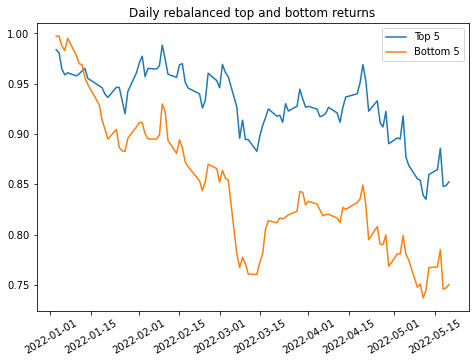

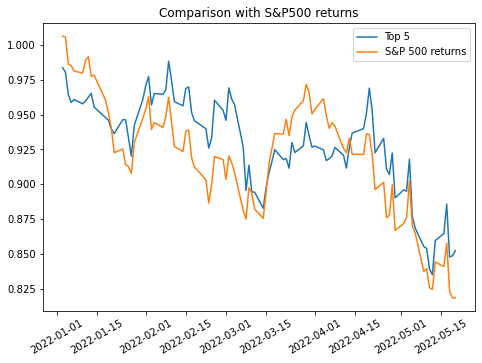

In [148]:
fig1 = plt.figure()
ax = fig1.add_axes([0,0,1,1])
ax.set_title('Daily rebalanced top and bottom returns')
line = ax.plot(top_cum_return, label='Top 5')
line2 = ax.plot(bottom_cum_return, label='Bottom 5')
ax.tick_params(axis='x', rotation=30)
ax.legend()

fig2 = plt.figure()
ax = fig2.add_axes([0,0,1,1])
ax.set_title('Comparison with S&P500 returns')
line = ax.plot(top_cum_return, label='Top 5')
line2 = ax.plot(cum_sp_returns, label='S&P 500 returns')
ax.tick_params(axis='x', rotation=30)
ax.legend()

print(print_text1)
print(print_text2)
print(print_text3)
print(print_text4)

From the analysis of the above graphs we note that:
- companies in the top 5 of the sentiment score performed (almost always) better than companies in the bottom 5
- the top 5 portfolio offers attractive returns when compared with S&P500 returns
- equal weighting is clearly not the best solution since there are large drawdowns in the top 5 portfolio

We now want to separate periods of over- and underperformance:

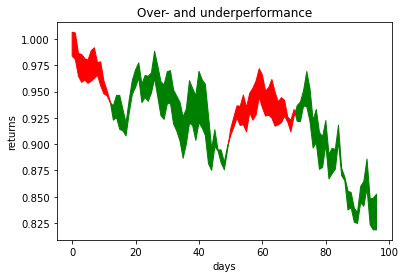

In [203]:
plt.fill_between(np.arange(len(cum_sp_returns)),top_cum_return, cum_sp_returns,
                where=(top_cum_return > cum_sp_returns), color='green',
                interpolate=True)
plt.fill_between(np.arange(len(cum_sp_returns)),top_cum_return, cum_sp_returns,
                where=(top_cum_return < cum_sp_returns), color='red',
                interpolate=True)
plt.title('Over- and underperformance')
plt.xlabel('days')
plt.ylabel('returns')
plt.show()

or:

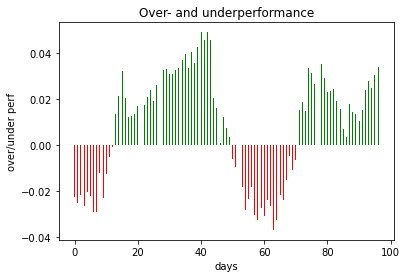

In [215]:
colors = ['green' if (x > 0) else 'red' for x in (top_cum_return-cum_sp_returns)]
plt.bar(np.arange(len(cum_sp_returns)), top_cum_return-cum_sp_returns, width=0.3, color=colors)
plt.title('Over- and underperformance')
plt.xlabel('days')
plt.ylabel('over/under perf')
plt.show()

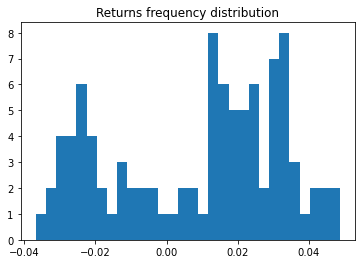

In [214]:
plt.hist(top_cum_return-cum_sp_returns, bins=30)
plt.title('Returns frequency distribution')
plt.show()

There are many ways in which this work can be improved:
- **increase accuracy of sentiment analyser**: this will decrease the peak that we have seen for the composite score equal to zero
- **longer news**: we only analysed the titles of the news, but an optimized code may read ans analyse the full article
- **build portfolios based on statistical measures**: top and bottom 5 is a simplistic and arbitrary rule. We could decide how many stock to go long or short based on quantile measures or on historical trends
- **portfolio weights**: equal weights is a simplistic measure that is suboptimal to other weighting schemes like inverse volatility
- **backtest**: a rigorous backtest is not possible since most of the past news are not stored on finviz so we end up with many NaN for values in the past
- **long/short**: I did not do a L/S strategy because including brokerage fees was too complex. But maybe a L/S one may perform better than a L only

Though it seems to me that the strategy performs well when there are large sell-offs in the market! In any case this claim should be validated by some solid econometrics.

<a id='9'></a>
## 9. A *very* basic API

In [101]:
from flask import Flask
from flask_restful import Resource, Api, reqparse
#from flask import send_file

import pandas as pd
import datetime

# Initialize flask library
app = Flask("My App")
api = Api(app)    

# Load csv files from the previous parts
d1 = pd.read_csv('out.csv')

# Convert some columns to omogeneous variables to avoit formatting errors
d1['ticker'] = d1['ticker'].apply(lambda x : str(x))
d1['compound'] = d1['compound'].apply(lambda x : float(x))
d1["date"]=d1["date"].apply(lambda x : datetime.datetime.strptime(str(x), '%Y-%m-%d').timestamp())

# Define the first request for the API
class GetTicker(Resource):

    def get(self):
        parser = reqparse.RequestParser()
        parser.add_argument('Ticker', required = False) # If the ticker is mandatory for the request, change to True
        #parser.add_argument('compound', required=False)
        args = parser.parse_args()
        
        # Args is a dictionary
        data = pd.DataFrame()
        if args['Ticker'] is not None:
            data = d1[d1['ticker'] == args['Ticker']]
            
        companies = [data.iloc[i].to_dict() for i in range(len(data))]
        return companies, 200

# Define the seocnd request for the API
class GetDate(Resource):
    
    def get(self):
        parser = reqparse.RequestParser()
        parser.add_argument('from', required = False) # If the ticker is mandatory for the request, change to True
        parser.add_argument('to', required=False)
        args = parser.parse_args()
        
        # Args is a dictionary
        data = pd.DataFrame()
        if args['from'] is not None:
            data = d1[d1['date'] >= float(datetime.datetime.strptime(str(args['from']), '%Y-%m-%d').timestamp())]
        
        if args['to'] is not None:
            data = d1[d1['date'] <= float(datetime.datetime.strptime(str(args['to']), '%Y-%m-%d').timestamp())]
        
        data2 = [data.iloc[i].to_dict() for i in range(len(data))]
        return  data2 , 200 
    
# Define the third request for the API
class GetResults(Resource):
    def get(self):
        parser = reqparse.RequestParser()
        parser.add_argument('results', required = False) # If the ticker is mandatory for the request, change to True
        args = parser.parse_args()
        # Open text files from the third part of the project
        # Run the third file before running this
        f=open("text1.txt", "r")
        if f.mode == 'r':
            print_text1 =f.read()

        f=open("text2.txt", "r")
        if f.mode == 'r':
            print_text2 =f.read()

        f=open("text3.txt", "r")
        if f.mode == 'r':
            print_text3 =f.read()

        f=open("text4.txt", "r")
        if f.mode == 'r':
            print_text4 =f.read()

        # Args is a dictionary
        data = pd.DataFrame()
        if args['results'] is not None:
            data = [print_text1, print_text2, print_text3, print_text4]
            
        data3 = data
        
        return  data3, 200 
              
# Set the parameters to execute the code above in the API
api.add_resource(GetDate, '/timeframe')
api.add_resource(GetTicker, '/get')
api.add_resource(GetResults, '/getresults')

if __name__=='__main__':
    app.run()  
    
# EXAMPLES
# Try using the code below to run the API in your browser
# http://127.0.0.1:5000/get?Ticker=WEC
# http://127.0.0.1:5000/timeframe?from=2021-11-01&to=2021-11-01
# http://127.0.0.1:5000/getresults?results

 * Serving Flask app "My App" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/May/2022 17:09:21] "GET / HTTP/1.1" 404 -
127.0.0.1 - - [19/May/2022 17:09:21] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [19/May/2022 17:09:29] "GET /get?Ticker=WEC HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2022 17:09:40] "GET /timeframe?from=2021-11-01&to=2021-11-01 HTTP/1.1" 200 -
127.0.0.1 - - [19/May/2022 17:09:53] "GET /getresults?results HTTP/1.1" 200 -
